In [1]:
import pandas as pd
import numpy as np
# import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

In [ ]:
pd.set_option('display.max_columns', None)

train = pd.read_csv('/Users/aritraray/Desktop/train_data_cleaned.csv', low_memory=False)

In [ ]:
train.head()

In [ ]:
train['date'] = pd.to_datetime(train['date'])

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder on the customer_code column
train['customer_code_encoded'] = label_encoder.fit_transform(train['customer_code'])

# Display the first few rows to check the encoding
print(train[['customer_code', 'customer_code_encoded']].head())


In [ ]:
# Convert all boolean columns (True/False) to integers (1/0)
train = train.map(lambda x: int(x) if isinstance(x, bool) else x)

# Display the first few rows to check the changes
print(train.head())

In [ ]:
df_encoded = train

In [ ]:
# List of columns you want to drop
columns_to_drop = ['customer_code', 'employee_index', 'join_channel', 'province_name', 'segment']  

# Drop the columns from the DataFrame
df_encoded = df_encoded.drop(columns=columns_to_drop)

# Display the first few rows to confirm the columns were dropped
df_encoded.head()

# New variables

Customers with higher income relative to the number of products they hold may indicate a propensity for wealth management.

In [ ]:
# 1. Income to Product Ratio
df_encoded['income_to_product_ratio'] = df_encoded['income'] / df_encoded['total_products'].replace(0, 1) 
df_encoded['income_to_product_ratio']

Income to Age Ratio: This metric helps identify customers who might have high disposable income.

In [ ]:
# 2. Income to Age Ratio
df_encoded['income_to_age'] = train['income'] / (df_encoded['age'] + 1e-5)  # Avoid division by zero
df_encoded['income_to_age']

In [ ]:
df_encoded['total_savings'] = (df_encoded['savings_acct'] + df_encoded['short_term_depo'] +
                           df_encoded['medium_term_depo'] + df_encoded['long_term_depo'])

In [ ]:
#Create function to calculate the probabiity

def calculate_product_probabilities(df, product_columns):
    product_counts = df_encoded[product_columns].sum()
    
    # Calculate total number of observations
    total_observations = len(df_encoded)
    
    # Calculate probabilities
    product_probabilities = product_counts / total_observations
    
    # Create a DataFrame to return
    probabilities_df = product_probabilities.reset_index()
    probabilities_df.columns = ['Product', 'Probability']

    probabilities_df = probabilities_df.sort_values(by='Probability', ascending=False)
    
    return probabilities_df

In [ ]:
product_columns = ['savings_acct', 'guarantees', 'current_acct', 'derivada_acct', 'payroll_acct', 
            'junior_acct', 'mas_particular_acct', 'particular_acct', 'particular_plus_acct', 
            'short_term_depo', 'medium_term_depo', 'long_term_depo', 'e_acct', 'funds', 
            'mortgage', 'pension', 'loans', 'taxes', 'credit_card', 'securities', 
            'home_acct', 'payroll_acct', 'pensions_2', 'direct_debt']

# Call the function with your DataFrame
probabilities = calculate_product_probabilities(df_encoded, product_columns)

# Display the resulting DataFrame
print(probabilities)

We will use this as a guidance to recommend the product.

In [ ]:
df_encoded.shape

# Feature Engineering

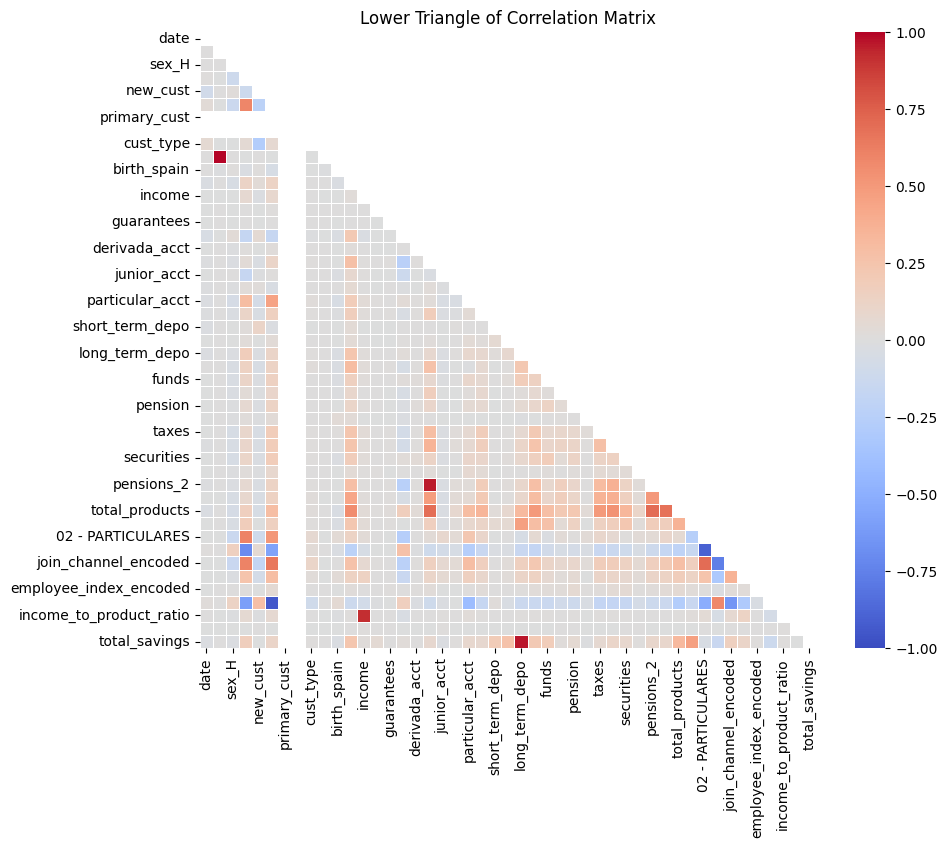

In [15]:
# Compute the correlation matrix
corr = df_encoded.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a seaborn heatmap with the mask for the upper triangle
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=.5)

# Display the plot
plt.title('Lower Triangle of Correlation Matrix')
plt.show()

Since these are vaguely correlated, it might not help to use PCA for dimension reduction

In [16]:
# Select numerical features 
numerical_features = train.select_dtypes(include=['float64', 'int64'])

# Standardizing the features
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# PCA Implementation
pca = PCA(n_components=0.95)  # Retain 95% of variance
principal_components = pca.fit_transform(numerical_features_scaled)

# Create a DataFrame for the PCA components
pca_columns = [f'pca_{i+1}' for i in range(principal_components.shape[1])]
train_pca = pd.DataFrame(data=principal_components, columns=pca_columns)

# Combine PCA components back with original DataFrame 
train = pd.concat([train.reset_index(drop=True), train_pca.reset_index(drop=True)], axis=1)

train.head()

,date,customer_code,employee_index,country,sex_H,age,new_cust,seniority_in_months,primary_cust,last_date_primary,cust_type,residency_spain,birth_spain,join_channel,province_name,active_cust,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,mas_particular_acct,particular_acct,particular_plus_acct,short_term_depo,medium_term_depo,long_term_depo,e_acct,funds,mortgage,pension,loans,taxes,credit_card,securities,home_acct,pensions_2,direct_debt,total_products,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,join_channel_encoded,province_name_encoded,employee_index_encoded,customer_code_encoded,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32
0,2015-06-28,16132,N,1,0,0.469388,0,0.953125,1,0,1,1,0,KAT,MADRID,0,0.115808,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.941089,1.749158,1.406991,162,-2.307107,-2.738776,0.015798,0.178602,-0.706919,0.142329,-0.392584,0.020112,0.121254,-0.036067,-0.248728,0.143575,-0.116814,-0.018755,0.004348,-0.254993,-0.466288,-0.197859,0.048055,-0.129905,-0.008445,-0.307617,-0.354104,-0.305329,0.559110,-0.154536,0.632281,-0.956129,-0.357079,0.456112,-1.670373,-0.395201
1,2015-06-28,1063040,N,1,0,0.234694,0,0.132812,1,0,1,1,0,KHE,VALENCIA,1,-0.255883,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0.887192,1.239384,1.406991,449826,1.595463,2.125202,-0.005706,0.356091,-0.625712,1.225518,0.873051,-0.041275,-0.117267,-0.589950,-0.073124,0.011608,-0.013948,-0.020262,0.056772,-0.272486,-0.472842,-0.409041,0.007086,-0.068853,-0.258643,-0.449097,-0.103151,-0.444123,0.023214,0.018755,0.187434,-0.291044,-0.420342,-0.417939,-0.468447,1.923338
2,2015-06-28,1063041,N,1,1,0.224490,0,0.132812,1,0,1,1,0,KHE,JAEN,1,-0.426794,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.887192,1.335167,1.406991,449827,2.392100,1.124349,0.003716,0.713653,-0.717190,0.510379,0.452985,0.272171,0.437359,-0.016616,0.072159,-0.081075,-0.306329,0.053131,-0.263134,0.138315,0.469400,0.628825,-0.082647,0.223933,0.157516,0.199586,0.119998,0.065908,0.092125,-0.067275,0.177612,-0.241037,-0.208781,-0.064525,-0.271084,0.143833
3,2015-06-28,1063042,N,1,1,0.244898,0,0.132812,1,0,1,1,0,KHE,CADIZ,0,-0.265831,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.887192,1.270557,1.406991,449828,2.726880,0.688002,0.001489,0.455214,-1.122082,-0.032876,-0.241143,-0.021071,0.325767,0.181096,0.044467,0.029303,-0.188034,0.044415,-0.199821,0.155824,0.339877,0.465128,-0.038177,0.132378,0.196484,0.325758,0.007520,0.173267,0.328701,0.095270,-0.029660,-0.189835,-0.077015,0.050815,-0.164537,-0.224511
4,2015-06-28,1063044,N,1,1,0.214286,0,0.132812,1,0,1,1,0,KHE,"CORUÑA, A",1,-0.167118,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.887192,1.134473,1.406991,449829,2.519281,1.171547,0.004936,0.727999,-0.819980,0.616313,0.380336,0.182064,0.381251,-0.109908,0.068337,-0.064651,-0.295879,0.040086,-0.258041,0.101548,0.347053,0.593232,-0.082082,0.218291,0.111740,0.227767,0.171126,0.109450,0.033209,0.126867,-0.500935,-0.098134,-0.267046,-0.003658,-0.192816,0.212318


In [17]:
#print the eigen values
print("Explained variance ratio of each component:", pca.explained_variance_ratio_)

Explained variance ratio of each component: [0.1573346  0.08661061 0.04762358 0.04400886 0.03402728 0.0309643
 0.0279885  0.02638194 0.0258424  0.02505477 0.02473029 0.02424058
 0.02395358 0.02382846 0.0237263  0.02350803 0.02342639 0.02317969
 0.02281548 0.0225141  0.02219573 0.02208624 0.02137472 0.02055166
 0.02033149 0.01886567 0.01798893 0.017166   0.01662334 0.01529206
 0.01460854 0.01269647]


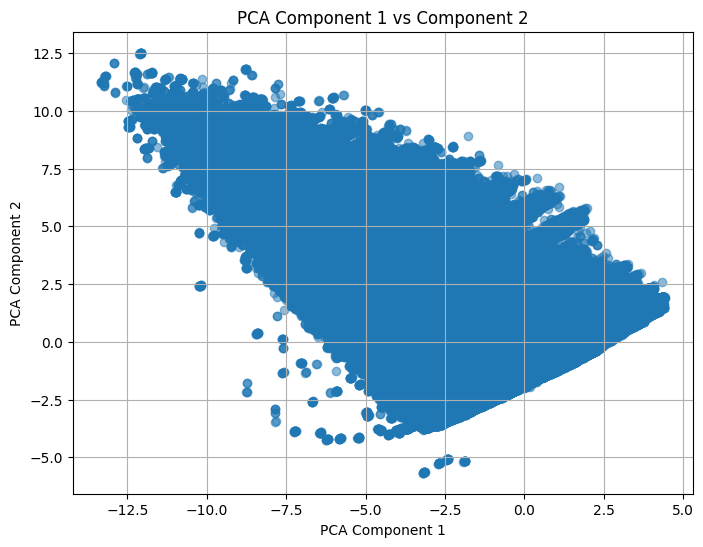

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(train['pca_1'], train['pca_2'], alpha=0.5)
plt.title('PCA Component 1 vs Component 2')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Feature selection

In [15]:
product_features = df_encoded[product_columns]

In [23]:
user_features = df_encoded.drop(columns=product_columns)
# user_features.drop('date', axis=1, inplace=True)

In [24]:
print("User Features Shape: ", user_features.shape)
print("Product Features Shape: ", product_features.shape)

User Features Shape:  (8224264, 23)
Product Features Shape:  (8224264, 24)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Initialize the RandomForestClassifier 
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model to user features and all product interactions (multi-label)
rf.fit(user_features, product_features)

# Select important features based on feature importance
selector = SelectFromModel(rf, threshold="mean", prefit=True)

# Get the selected feature names
selected_features = user_features.columns[selector.get_support()]

# Reduced dataset with selected features
reduced_train = user_features[selected_features]

print("Selected Features: ", selected_features)